In [1]:
%matplotlib inline

In [2]:
import athg4_parser as g4
import numpy as np
import glob
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import pandas as pd
import random as rm
from sklearn.cluster import DBSCAN

/data/soft/anaconda/4.1.1/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
g4dir = 'gcr_protons/gcr'

In [4]:
def get_summed_image_cutout_cent(deps):
    x =[]
    y = []
    for part in deps:
        for dep in part:
            x.append(dep[0])
            y.append(dep[1])
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    xcent, ycent = np.mean([xmin, xmax]), np.mean([ymin, ymax])
    sz_x, sz_y = 50, 50
    im = np.zeros((int(sz_x), int(sz_y)))
    for part in deps:
        for dep in part:
            ix = int(dep[0]) - int(xcent) + int(sz_x/2)
            iy = int(dep[1]) - int(ycent) + int(sz_y/2)
            if ix >=0 and ix < sz_x and iy >= 0 and iy < sz_y:
                im[ix, iy] += dep[2]*100  # offset pixels
    return im

In [5]:
events = []
num = 0
for fn in sorted(glob.glob(g4dir + '/*')):
    num += 1
    if(num > 10):
        break
    print(fn)
    try:
        events += g4.parse(fn)
    except:
        continue

# put the events into a pandas dataframe
gcr_df = g4.to_dataframe(events)
gcr_dfg = gcr_df.groupby('eid')

gcr_protons/gcr/100_detector0
gcr_protons/gcr/100_detector1
gcr_protons/gcr/100_detector2
gcr_protons/gcr/100_detector3
gcr_protons/gcr/10_detector0
gcr_protons/gcr/10_detector1
gcr_protons/gcr/10_detector2
gcr_protons/gcr/10_detector3
gcr_protons/gcr/11_detector0
gcr_protons/gcr/11_detector1


In [6]:
num = 0
gcr_im = []
gcr_labels = []
for eid in set(gcr_df.eid):
    im = get_summed_image_cutout_cent(gcr_dfg.get_group(eid).deps)
        
    num += 1
        
    gcr_im.append(im)
    
        
gcr_im = np.array(gcr_im)

In [7]:
evlfile = 'test.raw'

In [8]:
f = pyfits.open(evlfile)
df = pd.DataFrame({'FRAME' : f['EVENTS'].data['FRAME'].byteswap().newbyteorder('<'),
                   'PHA' : f['EVENTS'].data['PHA'].byteswap().newbyteorder('<'),
                   'RAWX' : f['EVENTS'].data['RAWX'].byteswap().newbyteorder('<'),
                   'RAWY' : f['EVENTS'].data['RAWY'].byteswap().newbyteorder('<'),
                   })
f.close()
df_byframe = df.groupby('FRAME')

In [9]:
def get_frame_image(fr):
    x = []
    y = []
    for i,r in df_byframe.get_group(fr).iterrows():
        x.append(r.RAWX)
        y.append(r.RAWY)
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    xcent, ycent = np.mean([xmin, xmax]), np.mean([ymin, ymax])
    sz_x, sz_y = 50, 50
    im = np.zeros((int(sz_x), int(sz_y)))
    for i,r in df_byframe.get_group(fr).iterrows():
        ix = r.RAWX - int(xcent) + int(sz_x/2)
        iy = r.RAWY - int(ycent) + int(sz_y/2)
        if ix >=0 and ix < sz_x and iy >= 0 and iy < sz_y:
            im[ix, iy] += r.PHA  # offset pixels
    return im

In [10]:
num = 0
xr_im = []
xr_labels = []
lim = 20000
for fr in set(df.FRAME):
    num += 1
    if num > lim:
        break
    im = get_frame_image(fr)
        
    xr_im.append(im)
xr_im=np.array(xr_im)

In [25]:
count=0
photon_index=0
particle_index=0
no_conn_num=0
train_im=[]
train_label=[]
while True:
    photon_num=rm.randint(0,1)
    particle_num=rm.randint(0,2)
    while photon_num==0 and particle_num==0:
        photon_num=rm.randint(0,1)
        particle_num=rm.randint(0,2)
    if photon_num==1:
        while np.nonzero(xr_im[photon_index])[0].shape[0]==0:
            photon_index+=1
        train_im.append(xr_im[photon_index])
        photon_index+=1
        train_label.append(1)
    else:
        train_im.append(np.zeros((50,50)))
        train_label.append(0)
    if particle_num>=1:
        while np.nonzero(gcr_im[particle_index])[0].shape[0]==0:
            particle_index+=1
        dx=rm.randint(-3,3)
        dy=rm.randint(-3,3)
        im_shift=np.roll(gcr_im[particle_index],dx,axis=1)
        im_shift=np.roll(im_shift,dy,axis=0)
        train_im[count]+=im_shift
        particle_index+=1
    if particle_num==2:
        while np.nonzero(gcr_im[particle_index])[0].shape[0]==0:
            particle_index+=1
        dx=rm.randint(-3,3)
        dy=rm.randint(-3,3)
        im_shift=np.roll(gcr_im[particle_index],dx,axis=1)
        im_shift=np.roll(im_shift,dy,axis=0)
        train_im[count]+=im_shift
        particle_index+=1
    y_max=np.nonzero(train_im[count])[0].max()
    y_min=np.nonzero(train_im[count])[0].min()
    x_max=np.nonzero(train_im[count])[1].max()
    x_min=np.nonzero(train_im[count])[1].min()
    dx=-int((x_max+x_min)/2)+25
    dy=-int((y_max+y_min)/2)+25
    train_im[count]=np.roll(train_im[count],dx,axis=1)
    train_im[count]=np.roll(train_im[count],dy,axis=0)
    count+=1
    
    X=np.transpose(np.nonzero(train_im[count-1]))
    clustering = DBSCAN(eps=3, min_samples=3).fit(X)
    
    
    if np.unique(clustering.labels_).shape[0]>1:
        no_conn_num+=1
        count-=1
        if no_conn_num<8:
            photon_index-=photon_num
            particle_index-=particle_num
        del train_im[count]
        del train_label[count]
    else:
        no_conn_num=0
    
    if particle_index>=10000:
        break

In [26]:
count=0
no_conn_num=0
test_im=[]
test_label=[]
while True:
    photon_num=rm.randint(0,1)
    particle_num=rm.randint(0,2)
    while photon_num==0 and particle_num==0:
        photon_num=rm.randint(0,1)
        particle_num=rm.randint(0,2)
    if photon_num==1:
        while np.nonzero(xr_im[photon_index])[0].shape[0]==0:
            photon_index+=1
        test_im.append(xr_im[photon_index])
        photon_index+=1
        test_label.append(1)
    else:
        test_im.append(np.zeros((50,50)))
        test_label.append(0)
    if particle_num>=1:
        while np.nonzero(gcr_im[particle_index])[0].shape[0]==0:
            particle_index+=1
        dx=rm.randint(-3,3)
        dy=rm.randint(-3,3)
        im_shift=np.roll(gcr_im[particle_index],dx,axis=1)
        im_shift=np.roll(im_shift,dy,axis=0)
        test_im[count]+=im_shift
        particle_index+=1
    if particle_num==2:
        while np.nonzero(gcr_im[particle_index])[0].shape[0]==0:
            particle_index+=1
        dx=rm.randint(-4,4)
        dy=rm.randint(-4,4)
        im_shift=np.roll(gcr_im[particle_index],dx,axis=1)
        im_shift=np.roll(im_shift,dy,axis=0)
        test_im[count]+=im_shift
        particle_index+=1
    y_max=np.nonzero(test_im[count])[0].max()
    y_min=np.nonzero(test_im[count])[0].min()
    x_max=np.nonzero(test_im[count])[1].max()
    x_min=np.nonzero(test_im[count])[1].min()
    dx=-int((x_max+x_min)/2)+25
    dy=-int((y_max+y_min)/2)+25
    test_im[count]=np.roll(test_im[count],dx,axis=1)
    test_im[count]=np.roll(test_im[count],dy,axis=0)
    count+=1
    
    X=np.transpose(np.nonzero(test_im[count-1]))
    clustering = DBSCAN(eps=3, min_samples=3).fit(X)
    if np.unique(clustering.labels_).shape[0]>1:
        no_conn_num+=1
        count-=1
        if no_conn_num<8:
            particle_index-=particle_num
            photon_index-=photon_num
            
        del test_im[count]
        del test_label[count]
    else:
        no_conn_num=0
 
    if particle_index>=16000:
        break

In [27]:
train_im=np.array(train_im)
train_label=np.array(train_label)
test_im=np.array(test_im)
test_label=np.array(test_label)

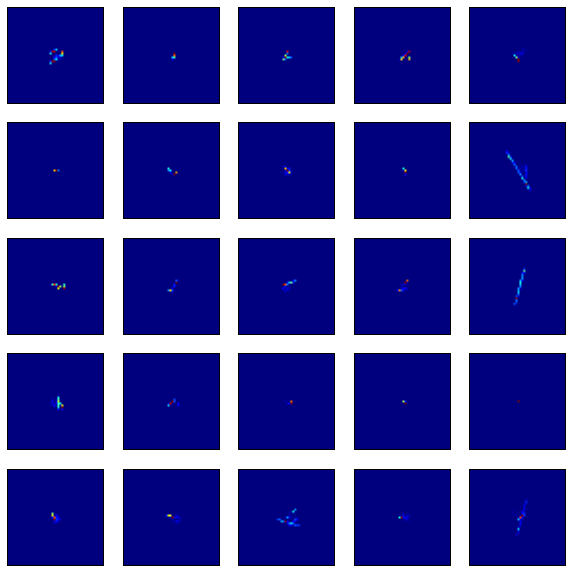

In [28]:
plt.figure(figsize=(10,10))
num=1
for im in train_im[0:25]: 
        plt.subplot(5,5,num)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(im)
        num+=1
plt.show()

In [38]:
train_im_all1=np.copy(train_im)
train_im_all1[np.nonzero(train_im_all1)]=1
test_im_all1=np.copy(test_im)
test_im_all1[np.nonzero(test_im_all1)]=1

In [39]:
import tensorflow as tf
from tensorflow import keras

In [40]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(50, 50)),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

#train_im = train_im.reshape(7500,50,50,1)
#test_im = test_im.reshape(4500,50,50,1)
model.fit(train_im_all1, train_label, epochs=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               640256    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 640,513
Trainable params: 640,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
7564/7564 [==============================] - 1s 168us/step - loss: 0.2144 - acc: 0.9085
Epoch 2/5
7564/7564 [==============================] - 1s 129us/step - loss: 0.0481 - acc: 0.9888
Epoch 3/5
7564/7564 [==============================] - 1s 122us/step - loss: 0.0216 - acc: 0.9946
Epoch 4/5
7564/7564 [==============================] - 1s 124us/step - loss: 0.0122 - acc: 0.9978
Epoch 5/

In [41]:
test_loss, test_acc = model.evaluate(test_im_all1, test_label)

print('Test accuracy:', test_acc)

4204/4204 [==============================] - 0s 91us/step
('Test accuracy:', 0.9900095147478591)


In [32]:
train_im_4=train_im.reshape((train_im.shape[0],50,50,1))
test_im_4=test_im.reshape((test_im.shape[0],50,50,1))
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(50, 50, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    keras.layers.Conv2D(64, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation=tf.nn.relu),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(train_im_4, train_label, epochs=5)
test_loss, test_acc = model.evaluate(test_im_4, test_label)

print('Test accuracy:', test_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 46, 46, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              5185000   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1001      
Total para

In [48]:
(train_label==0).sum()

3772